In [26]:
### This is largely inspired by HW2 but adapted to our needs

import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tqdm import tqdm
import cvxpy as cp
import time
import pandas as pd
import copy
from scipy.sparse import load_npz

# Note that we only use a distance computation function from sklearn (for sparse matrices), no learning agorithm from sklearn is used.
from sklearn.metrics import pairwise_distances

In [27]:
test_data = np.load('./test_data.pkl', allow_pickle=True)
training_data = np.load('./training_data.pkl', allow_pickle=True)
training_labels = np.load('./training_labels.pkl', allow_pickle=True)

train_set = training_data[:5000]
train_labels = training_labels[:5000]
val_set = training_data[5000:]
val_labels = training_labels[5000:]

In [28]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    # def kernel(self,X,Y):
        ## Input vectors X and Y of shape Nxd and Mxd

        # return np.exp( -( (X[...,:,None,:] - Y[...,None,:,:])**2).sum( axis = 2 )/(2.0*self.sigma) )
        # N = X.shape[0]
        # M = Y.shape[0]
        # return np.exp( - ( np.sum(X**2, axis = -1)[:,None] + np.sum(Y**2, axis = -1)[None,:] - 2*np.einsum('ij,kj->ik', X,Y)  )/(2.0*self.sigma) )


        ## LAPLACE 
        # log_result =  - np.sqrt(( (X.power(2)).sum(axis = -1) + ((Y.power(2)).sum(axis = -1)).T - 2*X@(Y.T)  ))/(self.sigma) 
        ## GAUSSIAN 
        # log_result =  - ( (X.power(2)).sum(axis = -1) + ((Y.power(2)).sum(axis = -1)).T - 2*X@(Y.T)  )/(2.0*self.sigma) 

        # result = np.exp(log_result )
        # return result
    
        # # we do a loop because otherwise we have an memory overflow
        # result = np.zeros((X.shape[-2], Y.shape[-2]))
        # # num_simultaneous_calculation = 10

        # for j in tqdm(range(result.shape[0])) :
        #     result[j] = np.exp( -( (X[j,None,:] - Y[:,:])**2).sum( axis = -1 )/(2.0*self.sigma) )
        # return(result)

        ## MIN MAX KERNEL !!
        # average = (X.sum(axis=-1) + Y.sum(axis=-1).T)/2.
        # difference =  pairwise_distances(X,Y, metric =  "cityblock")/2
    
        # max = average + difference
        # min = average - difference
        # min_max_kernel = min/(max + 0.00000000001)
        # return min_max_kernel


        
    def kernel(self,X,Y, indexes_of_change_size_subgraphs):
        #### equilibrated min_max kernel
        ## Input vectors X and Y of shape Nxd and Mxd

        result_kernel = np.zeros((X.shape[0], Y.shape[0]))
        indexes_of_change_size_subgraphs = list(indexes_of_change_size_subgraphs)
        indexes_of_change_size_subgraphs.append(X.shape[1])
        for i in range(len(indexes_of_change_size_subgraphs) - 1) :
            x = X[:,indexes_of_change_size_subgraphs[i]: indexes_of_change_size_subgraphs[i+1]]
            y = Y[:,indexes_of_change_size_subgraphs[i]: indexes_of_change_size_subgraphs[i+1]]
            average = (x.sum(axis=-1) + y.sum(axis=-1).T)/2.
            difference =  pairwise_distances(x,y, metric =  "cityblock")/2
        
            max = average + difference
            min = average - difference
            min_max_kernel = min/(max + 0.00000000001)
            result_kernel += min_max_kernel
        return result_kernel/(len(indexes_of_change_size_subgraphs))


In [29]:
class KernelSVC:
    
    def __init__(self, C, kernel, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel        
        self.alpha = None
        self.y = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y, indexes_of_change_size_subgraphs):
       #### You might define here any v ariable needed for the rest of the code
        N = len(y)
        y = copy.deepcopy(y)
        y[y==0] = -1

        self.y = y
        self.X = X
        self.support = None
        print("start kernel calculation at", time.time())
        K = self.kernel(X,X, indexes_of_change_size_subgraphs)
        print("finish at", time.time())

        ## IMPORTANCE PONDERATION !!
        ponderations = copy.deepcopy(y)
        ponderations[ponderations == 1] = 5455./555. # j'ai l'impression qu'on overfeat avec ça 
        # ponderations[ponderations == 1] = 1.0
        ponderations[ponderations == -1] = 1.0

        ### SECOND version of minimization : FAST ? 
        print("start minimization at ", time.time())
        y = y.reshape((-1,1))
        ponderated_y = ponderations.reshape((-1,1))*y
        ponderations = ponderations.reshape((-1,1))
        n = K.shape[0]
        alpha = cp.Variable((n, 1))
        K_ =  cp.Parameter(K.shape, PSD=True)
        constraints = [cp.multiply(y,alpha) >= 0, cp.multiply(y,alpha) <= self.C]

        objective = cp.Minimize( 0.5*cp.quad_form(cp.multiply(alpha,ponderations),K_)   - cp.sum(cp.multiply(ponderated_y,alpha) )   ) # 0.5*beta.reshape((1,-1))@K@beta - np.sum(alpha)
        problem = cp.Problem(objective, constraints)
        # assert problem.is_dpp() # is not important for us, we optimize only once
        K_.value = K
        problem.solve()
        
        alpha = problem.variables()[0].value * ponderated_y
        self.alpha = alpha.flatten()
        y = y.flatten()
        print("end minimization at ", time.time())
        ponderations = ponderations.flatten()
        ## Assign the required attributes
        print("alpha")
        for a in alpha :
            print(a)
        indices = np.nonzero( (self.alpha > self.epsilon*ponderations)*( self.alpha < ponderations*(self.C - self.epsilon)) )[0]
        print(np.nonzero( (self.alpha > self.epsilon*ponderations)*( self.alpha < ponderations*(self.C - self.epsilon))))
        self.support = X[indices]  #'''------------------- A matrix with each row corresponding to a point that falls on the margin ------------------'''
        print("the support is ",self.support.shape)
        self.b = y[indices[0]] - K[indices[0]]@(self.alpha*y) #''' -----------------offset of the classifier------------------ '''
        self.b = np.mean(y[indices] - K[indices]@(self.alpha*y)) #''' -----------------offset of the classifier------------------ '''

        beta = y*self.alpha
        self.norm_f = beta.reshape((1,-1))@K@beta  # '''------------------------RKHS norm of the function f ------------------------------'''


    ### Implementation of the separting function $f$ 
    def separating_function(self,x, indexes_of_change_size_subgraphs):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        output = (self.alpha*self.y).reshape((1,-1))@self.kernel(self.X,x, indexes_of_change_size_subgraphs)
        return output.flatten()
    
    
    def predict(self, X, indexes_of_change_size_subgraphs):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X, indexes_of_change_size_subgraphs)
        return 2 * (d+self.b) - 1

In [30]:
"""
notes :
WE SOLVED MINIMIZATION YOUHOOOOO : now kernel calculation is the choke point because it takes too much space to do all at once.

for max_size_subgraph = 2 it takes about 15 seconds to calculate the kernel + 10 sec for vectorization + ? minutes for minimization = 2m20 YOUHOUUUUUU 
for max_size_subgraph = 5 it takes about 100 seconds for vectorization + 75 secs to calculate the kernel + 60 secs for minimization = 4.20 mins 
for max_size_subgraph = 10 it takes about    seconds for vectorization +  secs to calculate the kernel +  secs for minimization = ,,, mins 
"""

'\nnotes :\nWE SOLVED MINIMIZATION YOUHOOOOO : now kernel calculation is the choke point because it takes too much space to do all at once.\n\nfor max_size_subgraph = 2 it takes about 15 seconds to calculate the kernel + 10 sec for vectorization + ? minutes for minimization = 2m20 YOUHOUUUUUU \nfor max_size_subgraph = 5 it takes about 100 seconds for vectorization + 75 secs to calculate the kernel + 60 secs for minimization = 4.20 mins \nfor max_size_subgraph = 10 it takes about    seconds for vectorization +  secs to calculate the kernel +  secs for minimization = ,,, mins \n'

In [31]:
# sigma = 1.5
sigma = 1.
C= 100.
kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)


# train_set_length = len(train_set)
# val_set_length = len(val_set)
# Graphs = train_set + val_set 

# X = common_subgraph_vectorization(Graphs, 12)

# X_train = X[:train_set_length]
# X_val = X[train_set_length:]

max_subgraph_size = 5

X_training = load_npz('./vectorizations_ordered/X_train_max_subgraph_' + str(max_subgraph_size) + '.npz')
indexes_of_change_size_subgraphs = np.load("./vectorizations_ordered/indexes_of_change_size_subgraphs_" + str(max_subgraph_size) + ".npy")
X_train = X_training[:5000]
X_val = X_training[5000:]

print("size of the vectors is ", X_train[0].shape)

model.fit(X_train,train_labels, indexes_of_change_size_subgraphs)


size of the vectors is  (1, 5219)
start kernel calculation at 1681326793.0257084
finish at 1681326795.399862
start minimization at  1681326795.400367


/home/roland/miniconda3/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:200: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


end minimization at  1681326869.746627
alpha
[4.94902554e-18]
[9.13641535]
[-2.7165664e-18]
[8.21621885e-19]
[5.21359404]
[13.40179699]
[4.49079018]
[0.95773007]
[-3.36942981e-18]
[-1.83917972e-18]
[-1.07841796e-18]
[-6.48964759e-20]
[-1.36592812e-18]
[1.86029632e-19]
[9.59115233]
[1.83831618e-18]
[-8.70314977e-18]
[7.33955377]
[1.07832786e-17]
[5.14471321]
[3.6466953e-19]
[-4.84608734e-19]
[-7.53867262e-19]
[0.35276715]
[0.20877506]
[-2.52003407e-18]
[4.33591071]
[-1.60736788e-18]
[0.4121102]
[1.71382653]
[1.22383073e-18]
[-4.06440011e-21]
[-4.73999427e-19]
[5.50502386]
[1.34344329e-19]
[5.00766985]
[-2.6192488e-17]
[2.74690412]
[-3.19467639e-18]
[1.84030881]
[0.03629213]
[3.71587138]
[7.98919904]
[4.20062957]
[1.69740548]
[-5.233521e-19]
[-1.26279299e-17]
[13.55849478]
[2.18403601]
[-2.89170845e-17]
[5.84698517]
[0.23832173]
[1.90280284]
[-3.32728642e-19]
[5.61448283e-20]
[7.41129273e-19]
[-5.55626347e-18]
[4.72455912]
[-6.18233023e-19]
[0.47332711]
[-4.19892917e-18]
[-7.86666742e-19

In [32]:
### IDEA 

In [33]:
estimated_val_labels = np.array( model.predict(X_val,indexes_of_change_size_subgraphs) ).flatten()


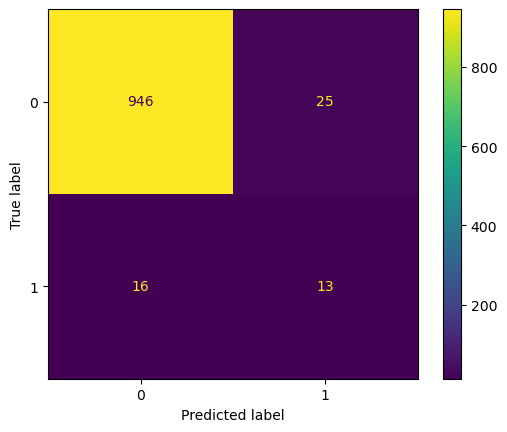

In [34]:
import matplotlib.pyplot as plt
from sklearn import metrics

estimated_val_labels_rounded = ((estimated_val_labels + 1)/2 >0).astype('int')
actual = val_labels.flatten()
predicted = np.array(estimated_val_labels_rounded).flatten()

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

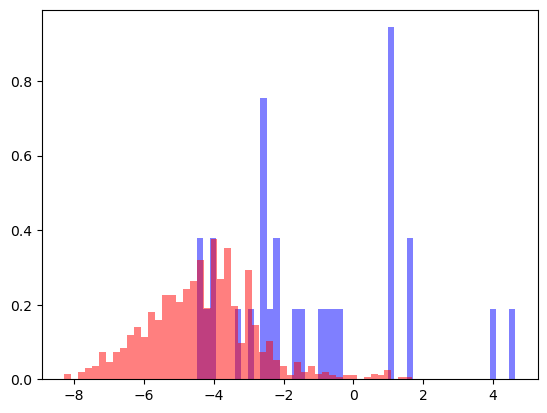

In [35]:
true_ones_indexes = np.argwhere(val_labels == 1)

bins = 50
plt.hist( estimated_val_labels[val_labels == 1],bins = bins, density = True, alpha=0.5, color = 'b' )
plt.hist( estimated_val_labels[val_labels == 0],bins = bins, density = True, alpha=0.5, color = 'r' )
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(val_labels, estimated_val_labels)
print(auc)

0.8783870165843958


In [37]:
# max_8 not ponderated  :::: AUC = 0.8706452643914911
# max_8 ponderated  :::: AUC = 0.8662416989239674
# max_10 sans pondéeation :::: AUC = 0.8685322632195746
# max_10 avec pondéeation :::: AUC = 0.8681593806598245

# max 3  avec pondération MAIS avec kernel rééquilibré ::: AUC 0.8769132426577648
# max 3  avec pondération MAIS avec kernel rééquilibré ::: 0.8798607905110266 AVEC CORRECTIONS SOUS GRAPHS
# max 3  sans pondération MAIS avec kernel rééquilibré ::: 0.8589793671650272 AVEC CORRECTIONS SOUS GRAPHS

# max 5 avec ponde  MAIS avec kernel rééquilibré  :::: 0.8794523953265385
# max 5 sans pondé  MAIS avec kernel rééquilibré  ::::0.8663837494229198

# max 6 sans pondé mais avec kernel rééquilibré ::: 0.8715330800099437  C= 5.0
# max 6 sans pondé mais avec kernel rééquilibré ::: 0.8749778046095387  C= 100 
# max 6 avec pondé mais avec kernel rééquilibré ::: 0.8775347135906815 C= 100 
# max 6 avec pondé mais avec kernel rééquilibré ::: 0.8721012820057532 C= 1000
# max 6 avec pondé mais avec kernel rééquilibré ::: 0.8735928122447529 C= 50 



# max 8 avec pondé kernel rééq C=100 ::::0.8648211939344437 
# max 8 avec pondé kernel rééq C=10  0.8512908839092297
# max 8 sans pondé kernel rééq C=100 :::: 0.8631521005717533

# max 5 sans pondé kernel rééq C=10 :::::0.8737703753684435
# max 5 avec pondé kernel réeq C=10 :::::0.8692247594019675

# max 7 sans pondération kernel rééq C=100  ::::::0.867910792286658
# max 7 sans pondération kernel rééq C=100  ::::::0.8715685926346817
# max 6 avec pond kernel reeq C=100  0.8775347135906815

(5000,)
(5000,)
(5000,)


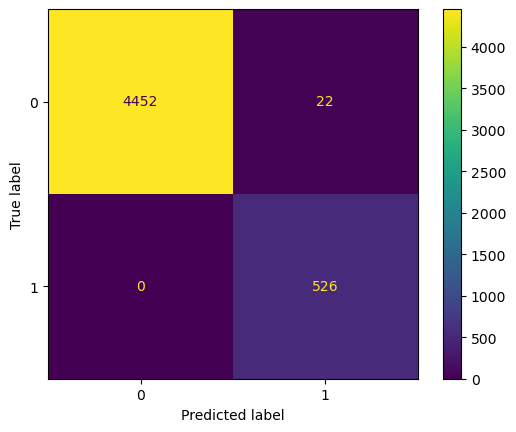

In [38]:
estimated_train_labels = np.array(model.predict(X_train,indexes_of_change_size_subgraphs)).flatten()
print(estimated_train_labels.shape)
estimated_train_labels_rounded = (((estimated_train_labels + 1)/2) > 0 ).astype('int') 

actual = train_labels.flatten()
predicted =  np.array(estimated_train_labels_rounded).flatten()
print(actual.shape)
print(predicted.shape)
confusion_matrix = metrics.confusion_matrix(actual, predicted) 

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

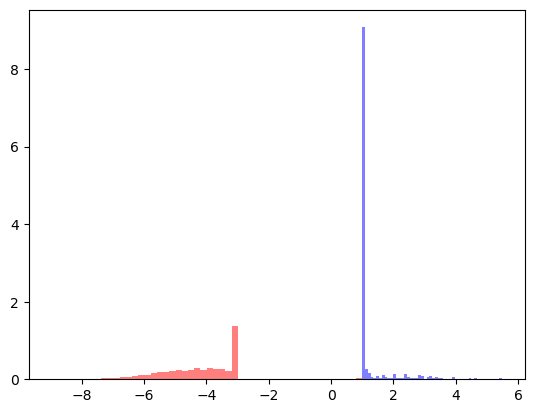

In [39]:
true_ones_indexes = np.argwhere(val_labels == 1)

bins = 50
plt.hist( estimated_train_labels[train_labels == 1],bins = bins, density = True, alpha=0.5, color = 'b' )
plt.hist( estimated_train_labels[train_labels == 0],bins = bins, density = True, alpha=0.5, color = 'r' )
plt.show()

In [40]:
class KernelPCA:
    
    def __init__(self,kernel, r=2):                             
        self.kernel = kernel          # <---
        self.alpha = None # Matrix of shape N times d representing the d eingenvectors alpha corresp
        self.lmbda = None # Vector of size d representing the top d eingenvalues
        self.support = None # Data points where the features are evaluated
        self.r =r ## Number of principal components
    def compute_PCA(self, X):
        # assigns the vectors
        self.support = X
        N = X.shape[0]
        K = kernel(X,X)
        G = K - 1.0/N*np.ones((N,N))@K - 1.0/N*K@np.ones((N,N)) + 1.0/N**2*np.ones((N,N))@K@np.ones((N,N))
        lmbda, alpha = np.linalg.eigh(G)
        lmbda = lmbda[::-1]
        alpha = alpha[:, ::-1]
        
#         lmbda, alpha = np.real(lmbda), np.real(alpha)
        
#         alpha = alpha/np.sqrt( np.einsum("ij,j",[alpha.T@G@alpha ) )
        self.lmbda = lmbda[0:self.r]
        self.alpha = alpha[:,0:self.r]
        for j in range(self.r) :
            self.alpha[:,j] = self.alpha[:,j]/np.sqrt(self.alpha[:,j].reshape((1,-1))@G@self.alpha[:,j].reshape((-1,1)) )
        
        #constraints = ({})
        # Maximize by minimizing the opposite
        
    def transform(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        K = self.kernel(self.support, x)
        N1, N2 = K.shape
        reponse = K - np.ones((N1,N1))/N1@K \
                 - K@np.ones((N2,N2))/N2 +  np.ones((N1,N1))/N1@K@np.ones((N2,N2))/N2
        return( reponse.T@self.alpha )
    


In [41]:

# train_set = X_train 
# val_set = X_val

# sigma = 0.1
# kernel = RBF(sigma).kernel
# pca = KernelPCA(kernel, r=3 )
# pca.compute_PCA(train_set)
# pca_components = pca.transform(val_set)

# fig, ax = plt.subplots(1,2, figsize=(11, 4))
# scatter_label_points(val_set, val_labels, ax[0], title='orginal data')
# scatter_label_points(pca_components[:,:2],val_labels, ax[1], title= 'transformed data')

# fig, ax = plt.subplots(1,3, figsize=(11, 4))
# scatter_label_points(val_set, val_labels, ax[0], title='orginal data')
# scatter_label_points(pca_components[:,1:3],val_labels, ax[1], title= 'along with second and third eigenvectors')
# scatter_label_points(pca_components[:,::2],val_labels, ax[2], title= 'along with first and third eigenvectors')


In [42]:
## this is to make the real predictions 



In [43]:
test_data = np.load('./test_data.pkl', allow_pickle=True)
training_data = np.load('./training_data.pkl', allow_pickle=True)
training_labels = np.load('./training_labels.pkl', allow_pickle=True)

In [44]:

kernel = RBF(sigma).kernel
model = KernelSVC(C=C, kernel=kernel)


# train_set_length = len(training_data)
# test_set_length = len(test_data)
# Graphs = training_data + test_data 

# X = common_subgraph_vectorization(Graphs, 5)

# X_train = X[:train_set_length]
# X_test = X[train_set_length:]

X_training = load_npz('./vectorizations_ordered/X_train_max_subgraph_' + str(max_subgraph_size) + '.npz')
X_test = load_npz('./vectorizations_ordered/X_test_max_subgraph_' + str(max_subgraph_size) + '.npz')
indexes_of_change_size_subgraphs = np.load("./vectorizations_ordered/indexes_of_change_size_subgraphs_" + str(max_subgraph_size) + ".npy")

model.fit(X_training,training_labels, indexes_of_change_size_subgraphs)


start kernel calculation at 1681326874.9513993
finish at 1681326878.2644844
start minimization at  1681326878.2647955


/home/roland/miniconda3/lib/python3.10/site-packages/cvxpy/reductions/solvers/solving_chain.py:200: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


end minimization at  1681327028.0477762
alpha
[5.82277829e-18]
[9.70135945]
[-3.09338819e-19]
[9.77798272e-19]
[5.33641445]
[14.59007945]
[1.01091603]
[0.92111893]
[-2.40112363e-18]
[-1.93906759e-18]
[-8.24317636e-19]
[-1.5246429e-18]
[-8.92088203e-19]
[5.89697412e-19]
[10.01640432]
[1.52499164e-18]
[-7.4354137e-18]
[6.84212607]
[1.23324177e-17]
[5.23391697]
[2.25868833e-19]
[0.0088731]
[-4.90891322e-19]
[0.29162271]
[0.08498955]
[-2.0267528e-18]
[3.91398519]
[-1.75403595e-18]
[0.32607675]
[2.17940479]
[-2.80416923e-19]
[2.05592975e-18]
[1.27434132e-18]
[5.7062015]
[3.42673156e-19]
[4.08334189]
[-2.82587503e-17]
[2.74510882]
[2.74757544e-19]
[1.60982484]
[1.34098976e-19]
[4.2074419]
[8.47086522]
[4.59829558]
[0.71662024]
[1.54540941e-19]
[-1.31582277e-17]
[21.27227155]
[1.33999536]
[-8.45705477e-17]
[5.63332301]
[0.14665443]
[1.94182867]
[1.2580035e-19]
[-1.47383609e-18]
[1.3798491e-18]
[-2.23602437e-18]
[5.45444221]
[1.75911249e-20]
[0.29914656]
[-2.47800951e-18]
[9.16320433e-20]
[0.1

In [45]:
"""
for 5 subgraph max size we have 
vectorization : 186 sec  kernel : 132 secs   minimization : 143secs 
sigma = 1.5  C=100.  gives support of shape (526, 5219) 

"""

'\nfor 5 subgraph max size we have \nvectorization : 186 sec  kernel : 132 secs   minimization : 143secs \nsigma = 1.5  C=100.  gives support of shape (526, 5219) \n\n'

In [46]:
estimated_test_labels = np.array(model.predict(X_test,indexes_of_change_size_subgraphs)).flatten()


In [47]:
print(estimated_test_labels)

[-5.15694307 -2.79671051 -2.6689369  ... -6.03518005  4.70473065
 -4.01580562]


In [48]:
for x in estimated_test_labels:
    print(x)

-5.1569430748560485
-2.796710514103513
-2.668936900495073
-2.7958537322111465
-1.0938621351661095
-3.117905946196846
-3.503436539158788
-1.7711581091096673
-2.1665070416118124
-3.337020011337206
-4.53670504612818
-3.099883789516771
-1.082317908076352
-4.216362305658112
-4.615014960360174
-4.894106022192393
-2.760819146610477
-4.074385675950698
-5.154479987822146
0.437117223358523
-4.348533805363804
-4.375982599835414
-1.4334772876783473
-3.3845387893319594
-2.650587124825354
-3.675326712179914
-2.902992915517832
-1.4851976356013847
-2.6098882339138822
-2.1124094406386758
-1.4122531032484358
-3.337020011337206
-3.1909318934499606
-4.902456981784741
-4.054197495621015
-4.887900387067493
-3.254663608428832
-4.855738111902031
-1.2650471459999335
-4.187761437895308
-3.1909318934499606
-2.227305739156027
-4.126460928450189
-3.515365921397223
-3.117905946196846
-4.043636384687677
-0.8010747740195439
-3.676557029423425
-2.292869633446021
-2.320665719954509
-4.894106022192393
-4.426064939954973

In [49]:

Yte = {'Predicted' : np.round(np.array(estimated_test_labels).flatten(),3)} 
df = pd.DataFrame(Yte) 
df.index += 1 
df.to_csv('test_pred.csv',index_label='Id')

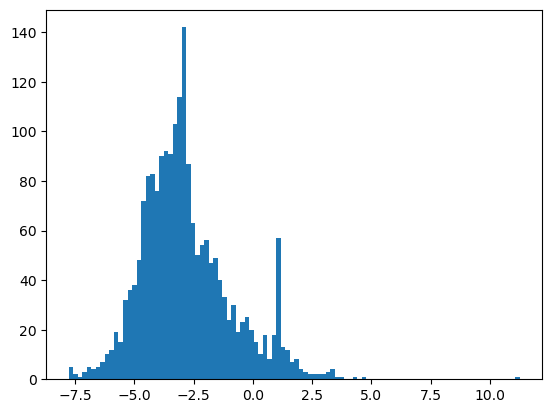

In [50]:
plt.hist(np.array(estimated_test_labels).flatten(), bins = 100)
plt.show()